Using:
    https://gist.github.com/EdwardJRoss/86b31848a7951411de56f10f55e9de4e
    https://forums.fast.ai/t/character-level-language-model/31379
    
Lesson 3 RNN

Offline steps:

1. Combine scraped files
2. Use Notepad++ to convert encoding to UTF8
3. sort out carriage returns etc.
4. End up with rawest_just_eat.csv 

Long story:
1. Get raw scraped files
2. Open them in Notepad++ and choose Encode in UTF8
3. This didn't work for #7 which had to be saved as unicode text and then saved as UTF 8
4. Then knit them together in Python


In [97]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [98]:
from fastai import *
from fastai.text import *
import string
from unidecode import unidecode


In [99]:
df = pd.read_csv('/home/trpb2/data/takeaway/rawest_just_eat.csv')

In [100]:
my_dir = '/home/trpb2/takeaways/data/scraped/'

In [101]:
df_temp = pd.concat([pd.read_csv(my_dir+f) for f in os.listdir(my_dir)], ignore_index = True)

In [102]:
df = df_temp[['Name','Cuisines']]

In [103]:
df = pd.concat([df['Name'], df['Cuisines'].str.split(', ', expand=True)], axis=1)

In [104]:
df.columns = ['text','label','label2','label3']

In [105]:
df[df.label2.isna()]

,text,label,label2,label3
2,KFC Derby - Westfield Centre,Chicken,None,None
17,Bucky's Restaurant,African,None,None
26,KFC Barnsley Peel Street,Chicken,None,None
27,The Balti,Indian,None,None
31,Chiquito - Nottingham Cornerhouse,Mexican,None,None
43,Chiquito - Trowbridge,Tex Mex,None,None
44,KFC Cippenham,Chicken,None,None
52,Birdbox - Edinburgh The Gyle,Chicken,None,None
59,Cheung Sing,Chinese,None,None
64,Abertillery Kebab House,Kebab,None,None


In [106]:
df.dropna(thresh=3, inplace=True)

In [107]:
df['text'] = df.text.str.lower()

In [108]:
df['text'] = df.text.str.strip()
df['label'] = df.label.str.strip()
df['label2'] = df.label2.str.strip()
df['label3'] = df.label3.str.strip()

## Character Set

What letters outside of ASCII are in the names? Convert to ascii


In [109]:
foreign_chars = Counter(_ for _ in ''.join(str(list(df.text))) if _ not in string.ascii_letters)
foreign_chars.most_common()


[(' ', 84450),
 ("'", 58978),
 (',', 31157),
 ('"', 6346),
 ('&', 2867),
 ('-', 2409),
 ('®', 579),
 ('(', 366),
 (')', 366),
 ('1', 274),
 ('2', 273),
 ('’', 250),
 ('.', 215),
 ('@', 195),
 ('4', 141),
 ('3', 119),
 ('0', 119),
 ('8', 84),
 ('6', 81),
 ('9', 80),
 ('7', 79),
 ('5', 73),
 ('!', 68),
 ('é', 28),
 ('`', 23),
 ('´', 19),
 ('/', 18),
 ('#', 7),
 ('‘', 7),
 ('+', 6),
 (':', 4),
 ('?', 4),
 ('–', 3),
 ('*', 3),
 ('ó', 2),
 ('%', 2),
 ('ê', 2),
 ('ö', 2),
 ('è', 2),
 ('[', 1),
 ('á', 1),
 ('\\', 1),
 ('ä', 1),
 ('~', 1),
 ('ü', 1),
 ('°', 1),
 (']', 1)]

In [110]:
df['ascii_name'] = df.text.apply(lambda x: unidecode(str(x)))
df[df.text != df.ascii_name]

,text,label,label2,label3,ascii_name
66,subway® - 7 wellmeadow street,Sandwiches,Lunch,Halal,subway(r) - 7 wellmeadow street
103,café bagel,Bagels,Vegan,None,cafe bagel
110,ollie’s kebab ye / fish&chips,Kebab,Fish & Chips,None,ollie's kebab ye / fish&chips
121,subway® gravesend high street,Subways,Sandwiches,None,subway(r) gravesend high street
129,hennie penny’s chicken,Chicken,American,None,hennie penny's chicken
213,subway® - london road,Sandwiches,Halal,None,subway(r) - london road
241,subway® - charon way,Sandwiches,Lunch,None,subway(r) - charon way
336,subway® wakefield drive thru,Subways,Sandwiches,None,subway(r) wakefield drive thru
387,subway® - coventry high street,Sandwiches,Lunch,None,subway(r) - coventry high street
392,subway®- 9/11 high street,Sandwiches,Lunch,None,subway(r)- 9/11 high street


In [111]:
foreign_chars = Counter(_ for _ in ''.join(str(list(df.ascii_name))) if _ not in string.ascii_letters)
foreign_chars.most_common()

[(' ', 84450),
 ("'", 58728),
 (',', 31157),
 ('"', 6872),
 ('&', 2867),
 ('-', 2412),
 ('(', 945),
 (')', 945),
 ('1', 274),
 ('2', 273),
 ('.', 215),
 ('@', 195),
 ('4', 141),
 ('3', 119),
 ('0', 119),
 ('8', 84),
 ('6', 81),
 ('9', 80),
 ('7', 79),
 ('5', 73),
 ('!', 68),
 ('`', 23),
 ('/', 18),
 ('#', 7),
 ('+', 6),
 (':', 4),
 ('?', 4),
 ('*', 3),
 ('%', 2),
 ('[', 1),
 ('\\', 1),
 ('~', 1),
 (']', 1)]

In [112]:
# remove or replace some characters
df['ascii_name_fix'] = df.ascii_name.str.replace('`',"'")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('~'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace(']'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('['," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('\\'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('%'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('*'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace(':'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('+'," and ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('&'," and ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('/'," ")
suss_chars = ['`',']','%','&']
df[df.ascii_name_fix.str.contains('|'.join(suss_chars))]

,text,label,label2,label3,ascii_name,ascii_name_fix


In [113]:
df = df.drop(columns=['text', 'ascii_name'])

In [114]:
len(df) # all data still intact

31035

## Get rid of some chains
There are some chains in the data set that have been identified by hand
1. Find them in rows using a regex
2. remove the rows
3. replace with a single row
4. for each label, take the most common. If no labels, replace with None
5. Set up columns called trim and trim2 for next section

Next, we look for places that look like chains because they have some information about the location,
normally separated from the name by "-" or "("

We remove those through a similar process.


In [115]:
hard_coded_chains = ["asda kitchen", "basilico", "bella italia", "birdbox", "blazing bird", "burger king", "caspian pizza", "chicken cottage", "chiquito", "firezza", "frankie & benny's", "gbk", "greggs", "harvester", "itsu", "kfc", "kick ass", "las iguanas", "papa john", "pizza hut", "stack & grill", "stacks", "subway", "tim horton", "toby carvery", "tortilla -", "turtle bay", "wimpy", "yo!"]
for chain in hard_coded_chains:
    to_drop = df[df.ascii_name_fix.str.contains(chain, regex= True, na=False)]
    df = df[~df.ascii_name_fix.isin(to_drop.ascii_name_fix.tolist())]
    to_append = {'ascii_name_fix' : chain, 'trim':chain, 'trim2':chain}
    labels = ['label','label2','label3']
    for l in labels:
        mode_l = to_drop[l].mode()
        if len(mode_l) > 0:
            to_append[l] = mode_l[0]
        else:
            #to_append[l] = np.nan
            to_append[l] = 'None'
    df = df.append(to_append, ignore_index=True)
    


In [116]:
len(df)

28857

In [117]:
# try to find other chains by looking for names with - or ()
# because you often see KFC - Basingstoke or KFC (Solihull)
df['trim'] = df['ascii_name_fix'].str.split(r' - ').str.get(0)
df['trim2'] = df['ascii_name_fix'].str.split(" \(").str.get(0)

In [118]:
# the suspect chains are the ones where the name after attempting splitting differs from the original name
sus_chains = df[(df['trim']!=df['ascii_name_fix'])|(df['trim2']!=df['ascii_name_fix'])]


In [119]:
# put all the suspected chains into a list
sus_chains = df[(df['trim']!=df['ascii_name_fix'])]['trim'].to_list()
sus_chains2 = df[(df['trim2']!=df['ascii_name_fix'])]['trim2'].to_list()
sus_chains_list = sus_chains + sus_chains2
len(sus_chains)

834

In [120]:
my_count = Counter(sus_chains_list)
counts = pd.DataFrame(my_count.most_common(), columns=['ascii_name_fix', 'count'])

In [121]:
# These are the chains and how many there are
counts[counts['count']>1]
#counts[counts['count']>1].mean()

,ascii_name_fix,count
0,frankie and benny's,79
1,harry ramsden,41
2,favorite chicken and ribs,34
3,roosters piri piri,31
4,the ice cream hub,28
5,wenzel's,27
6,cluxxx it,24
7,stack and grill by cafe rouge,22
8,pieminister,20
9,dixy chicken,20


In [122]:
# These are the ones we will remove
to_trim_down = counts.loc[counts['count']> 1,['ascii_name_fix']].ascii_name_fix.to_list()

In [123]:
for chain in to_trim_down:
    to_drop = df[df.ascii_name_fix.str.contains(chain, regex= True, na=False)]
    df = df[~df.ascii_name_fix.isin(to_drop.ascii_name_fix.tolist())]
    to_append = {'ascii_name_fix' : chain, 'trim':chain, 'trim2':chain}
    labels = ['label','label2','label3']
    for l in labels:
        mode_l = to_drop[l].mode()
        if len(mode_l) > 0:
            to_append[l] = mode_l[0]
        else:
            to_append[l] = 'None'
    df = df.append(to_append, ignore_index=True)
    


In [124]:
df = df.drop(columns=['trim', 'trim2', 'label3'])

In [125]:
len(df)

24121

## Check for duplicates


This section now just looks for duplicate names. These may or may not be chains, but you can't have 40 instances of Mama's Pizza or you will end up validating on something you trained on. So this code fixes that.

In [126]:
name_classes = df.groupby('ascii_name_fix').size().reset_index(name='counts')

In [127]:
name_classes[name_classes.counts > 1]

,ascii_name_fix,counts
28,1st class pizza,2
38,2-4-1 pizza,2
43,241 pizza,3
56,3 for 10 pizza,3
86,500 degrees pizzeria,3
100,7 spices,4
138,a mano,2
142,a taste of india,2
145,a touch of spice,3
149,a'la pizza and grill,2


Use similar logic to removing chains to take the most popular labels - find names with more that 1 instance in the data

In [128]:
to_dedupe = name_classes[name_classes['counts'] > 1]['ascii_name_fix'].to_list()

In [129]:
len(to_dedupe)

2047

In [130]:
# Note that we don't use a regex, but an exact match. This is to avoid removing too much
# If there was a duplicated name called chick, then this would remove a huge number of places.
for chain in to_dedupe:
    to_drop = df[df['ascii_name_fix'] == chain]
    df = df[df['ascii_name_fix'] != chain]
    to_append = {'ascii_name_fix' : chain}
    labels = ['label','label2']
    for l in labels:
        mode_l = to_drop[l].mode()
        if len(mode_l) > 0:
            to_append[l] = mode_l[0]
        else:
            to_append[l] = 'None'
    df = df.append(to_append, ignore_index=True)

In [131]:
df[['label','label2']] = df[['label','label2']].astype(str)

check for duplicate name label combinations

In [132]:
check_dedupe = df.groupby('ascii_name_fix').size().reset_index(name='counts')

In [133]:
check_dedupe[check_dedupe['counts'] > 1]

,ascii_name_fix,counts


In [134]:
#df.to_csv('/home/trpb2/takeaways/data/20_01_2020_just_eat_words.csv', index=False)


### Summary of all labels



In [135]:
label_count = df.groupby('label').ascii_name_fix.count().sort_values(ascending=False)

In [136]:
len(label_count)

130

In [137]:
label_count2 = df.groupby('label2').ascii_name_fix.count().sort_values(ascending=False)

In [138]:
len(label_count2)

141

In [139]:
list1 = df.label.to_list()
list2 = df.label2.to_list()

In [140]:
list3 = list1 + list2

In [141]:
my_count = Counter(list3)
counts = pd.DataFrame(my_count.most_common(), columns=['label', 'count']).set_index('label')['count']
#counts = pd.Series(my_count.most_common(), index = my_count.most_common().label)

In [142]:
counts.to_csv('/home/trpb2/takeaways/04_08_2020_label_counts.csv', index=True)

/home/trpb2/.conda/envs/fastai_v1/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [46]:
plt.rcParams['figure.figsize'] = (10,30)

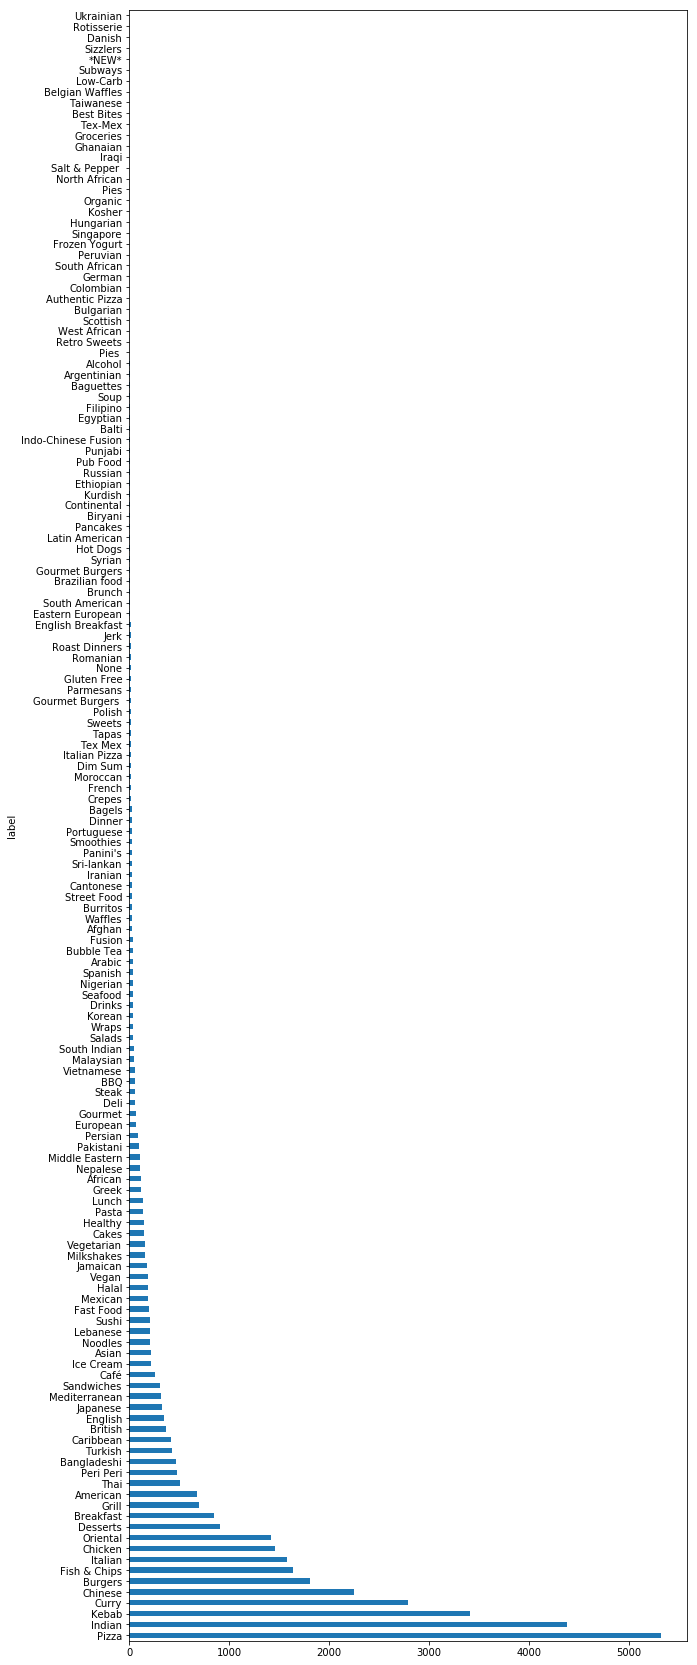

In [47]:
counts.plot(kind='barh')

### Investigate combinations of labels

In [48]:
df2 = pd.DataFrame(np.sort(df[['label', 'label2']], axis=1), index=df.index)
df2.columns = ['label', 'label2']
combos = df2.groupby(['label', 'label2']).size().reset_index(name='counts')

In [121]:
combos_10 = combos[combos['counts']>10]
combos[combos['label']=='Burgers'],combos[combos['label2']=='Burgers']

(       label             label2  counts
 296  Burgers            Burgers      12
 297  Burgers           Burritos       1
 298  Burgers               Café       5
 299  Burgers          Caribbean       9
 300  Burgers            Chicken     256
 301  Burgers            Chinese       1
 302  Burgers        Continental       1
 303  Burgers              Curry      17
 304  Burgers               Deli       2
 305  Burgers           Desserts      81
 306  Burgers             Dinner       1
 307  Burgers             Drinks       1
 308  Burgers            English       7
 309  Burgers  English Breakfast       2
 310  Burgers           European       4
 311  Burgers          Fast Food      15
 312  Burgers       Fish & Chips     115
 313  Burgers             French       3
 314  Burgers             Fusion       1
 315  Burgers            Gourmet      33
 316  Burgers    Gourmet Burgers       2
 317  Burgers              Greek       3
 318  Burgers              Grill      46
 319  Burgers   

In [143]:
len(df)

19341

## Crafting the mappings

Here we generate the mappings

In [144]:


mappings = {'Indian':'South Asian','Curry':'South Asian', 'Bangladeshi':'South Asian', 'Nepalese':'South Asian',
            'Pakistani':'South Asian', 'South South Asian':'South Asian', 'Sri Lankan':'South Asian',
            'Balti':'South Asian', 'Punjabi':'South Asian', 'Biryani':'South Asian', 'Sri-Lankan':'South Asian',
                'Ice Cream':'Desserts', 'Cakes':'Desserts', 'Milkshakes':'Desserts', 'Crepes':'Desserts', 'Waffles':'Desserts',
                'Italian':'Pizza', 'Italian Pizza':'Pizza',
                'Chinese':'Southeast & East Asian',
                'Noodles':'Southeast & East Asian', 'Oriental':'Southeast & East Asian', 'Cantonese':'Southeast & East Asian', 'Dim Sum':'Southeast & East Asian', 'Singapore':'Southeast & East Asian',
                'Taiwanese':'Southeast & East Asian',
                'Peri Peri':'Chicken',
                'Turkish':'Kebab',
                'Thai':'Southeast & East Asian', 'Japanese':'Southeast & East Asian', 'Sushi':'Southeast & East Asian', 'Korean':'Southeast & East Asian', 'Vietnamese':'Southeast & East Asian',
                'Bubble Tea':'Southeast & East Asian', 'Filipino':'Southeast & East Asian', 
                #'Turkish':'MedMid', 'Lebanese':'MedMid', 'Mediterranean':'MedMid', 'Greek':'MedMid', 'Middle Eastern':'MedMid',
                #'Persian':'MedMid', 'Afghan':'MedMid', 'Moroccan':'MedMid', 'Arabic':'MedMid', 'Syrian':'MedMid', 'Iranian':'MedMid',
                #'Iraqi':'MedMid',
                #'Tex Mex':'American', 'Spanish':'American', 'Tex Mex':'American',
                #'Brazilian food':'American', 'South American':'American', 'Burritos':'American', 'Mexican':'American',
                #'Steak':'American', 'Argentinian':'American', 'Latin American':'American', 'Colombian':'American',
                #'Peruvian':'American', 'Tex-Mex':'American',
                #'African':'AfroCarib','Caribbean':'AfroCarib', 'Jamaican':'AfroCarib', 'Nigerian':'AfroCarib', 'Jerk':'AfroCarib',
                # 'West African':'AfroCarib', 'Ethiopian':'AfroCarib', 'Ghanaian':'AfroCarib', 'North African':'AfroCarib',
                'Gourmet Burgers':'Burger', 'Burgers':'Burger', 'American':'Burger',
                'Café':'Sand/Caf/Bake', 'Sandwiches':'Sand/Caf/Bake', 'Wraps':'Sand/Caf/Bake', 'Bagels':'Sand/Caf/Bake', "Panini's":'Sand/Caf/Bake',
                "Salads":'Sand/Caf/Bake', "Baguettes":'Sand/Caf/Bake', "Deli":'Sand/Caf/Bake'
                ,'Breakfast':'Sand/Caf/Bake'
 }

key_list = ['South Asian', 'Southeast & East Asian', 'Fish & Chips']


In [169]:
df["label_orig"] = df.label
df["label2_orig"] = df.label2

In [170]:
df2 = df.replace({"label": mappings})
df3 = df2.replace({"label2": mappings})

In [171]:
#Fix in the most certain labels straight away
df3['label_final'] = np.where((df3['label2'].isin(key_list)), df3['label2'], 'no')
df3['label_final'] = np.where((df3['label'].isin(key_list)), df3['label'], df3['label_final'])

In [172]:
#Chinese places serving fish and chips are Chinese
df3['label_final'] = np.where(((df3['label'] == 'Fish & Chips') & (df3['label2'] == 'Chinese')), df3['label2'], df3['label_final'])

In [173]:
# this section for scanning names
name_scan = ['Burger', 'Chicken', 'Kebab', 'Pizza', 'Fast Food']

for name in name_scan:
    df3[name] = 0
    df3[name] = np.where(df3.ascii_name_fix.str.contains(name.lower(), regex= True, na=False), 1, 0)
    df3['label_final'] = np.where((df3.ascii_name_fix.str.contains(name.lower(), regex= True, na=False)), name, df3['label_final'])

    
df3['label_final'] = np.where(df3[name_scan].sum(axis = 1) > 1, 'Fast Food', df3['label_final'])


Optionally add the the Fast Food tag with outlets labelled with 2 or more of pizza, kebab, chicken, burger, fast food

Or, override these categories to Fast Food

In [150]:

#option to put something in fast food category if it has 2 labels in the list, rather that 2 words in its
# name that are on the fast food list

#fast_foods = ['Fast Food', 'Pizza', 'Burger', 'Kebab', 'Chicken']
#df3['label_final'] = np.where((df3['label'].isin(fast_foods)) & (df3['label2'].isin(fast_foods)) & 
#                              (df3['label'] != df3['label2']) & (df3['label_final'] == 'no'), 'Fast Food', df3['label_final'])


In [153]:
#take any remaining labels in our list of cuisines
my_cuisines =  ['Burger', 'Pizza', 'Kebab', 'Chicken', 'Chinese', 'Indian', 'Fish & Chips', 'Fast Food','Sand/Caf/Bake','Desserts']
df3['label_final'] = np.where((df3['label'].isin(my_cuisines) & (df3['label_final'] == 'no')), df3['label'], df3['label_final'])
df3['label_final'] = np.where((df3['label2'].isin(my_cuisines) & (df3['label_final'] == 'no')), df3['label2'], df3['label_final'])

In [154]:
#special section to convert all of 'Fast Food', 'Pizza', 'Burger', 'Kebab', 'Chicken' into single fast food
# category, can be commented out
#fast_foods = ['Fast Food', 'Pizza', 'Burger', 'Kebab', 'Chicken']
#df3['label_final'] = np.where(df3['label_final'].isin(fast_foods), 'Fast Food', df3['label_final'])

In [155]:
# Use this if a category is of lesser priority overall
#lesser =  ['Burger']
#df3['label_final'] = np.where((df3['label'].isin(lesser) & (df3['label_final'] == 'no')), df3['label'], df3['label_final'])
#df3['label_final'] = np.where((df3['label2'].isin(lesser) & (df3['label_final'] == 'no')), df3['label2'], df3['label_final'])

In [156]:
# Use this either take out left over burgers, or convert to fast food as it doesn't work well on its own
#df3 = df3[df3['label_final']!='Burger']
#df3['label_final'] = np.where(df3['label_final'] == "Burger", 'Fast Food', df3['label_final'])
#df3['label_final'] = np.where(df3['label_final'] == "Burger", 'Sand/Caf/Bake', df3['label_final'])

In [157]:
# either take out left over outlets that didn't make it into a category, or convert to other
df3 = df3[df3['label_final']!='no']
#df3['label_final'] = np.where(df3['label_final'] == "no", 'Other', df3['label_final'])

In [174]:
df3.sum()

label             ChickenKebabSouth AsianCaribbeanSouth AsianKeb...
label2            PizzaKebabSouth AsianFast FoodSouth AsianSouth...
ascii_name_fix    southern fried chicken  and  pizzaj  and  d ke...
label_orig        ChickenKebabIndianCaribbeanIndianKebabIndianIn...
label2_orig       PizzaTurkishCurryFast FoodCurryIndianCurryPizz...
label_final       Fast FoodKebabSouth AsiannoSouth AsianSouth As...
Burger                                                          323
Chicken                                                         670
Kebab                                                          1085
Pizza                                                          2369
Fast Food                                                       107
dtype: object

In [159]:
len(df3)

18145


### Investigate what ended up in each category

Check the quality of the mapping process


In [160]:
list1 = df3[df3['label_final']=='Burger'].label_orig.to_list()
list2 = df3[df3['label_final']=='Burger'].label2_orig.to_list()

In [161]:
list3 = list1 + list2

In [162]:
my_count = Counter(list3)
counts = pd.DataFrame(my_count.most_common(), columns=['label', 'count']).set_index('label')['count']
#counts = pd.Series(my_count.most_common(), index = my_count.most_common().label)

In [163]:
plt.rcParams['figure.figsize'] = (10,15)

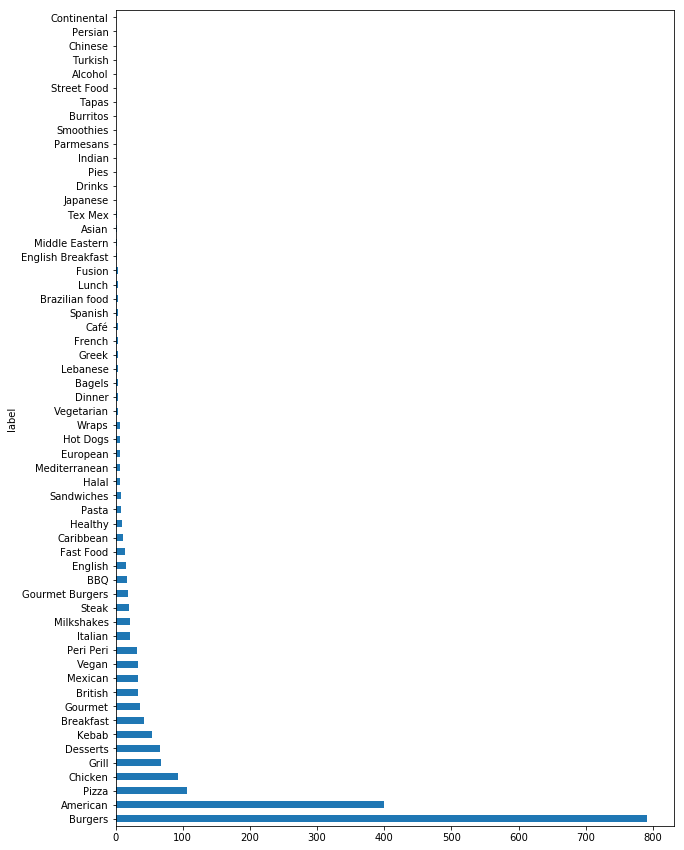

In [164]:
counts.plot(kind='barh')


## Create Validation and Training Sets

The main purpose of this section is an attempt to provide a balanced training dataset.
This is necessary because the categories are quite unequal. If you just sampled randomly, then you would do well on the more frequent categories. Equally the validation set should have equal numbers from each category.

The parameter train_size sets the MINIMUM data size in each category. If a category has more than the minimum, then all the data are used. If a category has less than the minimum then the data are resampled at random up to the minimum.

For completeness there is the option just to have the same number of data items in each category. In this case, if there are less than the number required, the complete data set is taken for the category and the remainder filled up with random samples.


In [165]:
df3 = df3.reset_index().drop('index', 1)

In [175]:
counts = df3.groupby('label_final').ascii_name_fix.count().sort_values(ascending=False)
counts

label_final
no                        6922
South Asian               4439
Southeast & East Asian    2790
Pizza                     1758
Fish & Chips              1354
Fast Food                  772
Kebab                      622
Chicken                    450
Burger                     234
Name: ascii_name_fix, dtype: int64

In [457]:
valid_size = 400
train_size = 4000 # The minimum for training. If less than this we will sample up to this level

In [458]:
np.random.seed(6011)
valid_idx = []
for label in counts.keys():
    # Random sample of size "valid_size" for each class
    valid_idx += list(df3[df3.label_final == label].sample(valid_size).index)

In [459]:
df3['valid'] = False
df3.loc[valid_idx, 'valid'] = True

In [460]:
#This code could be used if you want to enforce the same number of training data items in each class.
# That is train_size is a maximum as well as minimum
# Good if you want to limit to a particular size
#np.random.seed(7012)
#balanced_idx = []
#for label in counts.keys():
#    if (counts[label] - valid_size) < train_size:
#        # If there is not enough training data, take what there is then randomly sample rest
#        balanced_idx += list(df3[(df3.label_final == label) & ~df3.valid].sample(counts[label]-valid_size, replace=False).index)
#        balanced_idx += list(df3[(df3.label_final == label) & ~df3.valid].sample(train_size - (counts[label]-valid_size), replace=True).index)
#    else:
#        # If there is enough data, sample without replacement
#        balanced_idx += list(df3[(df3.label_final == label) & ~df3.valid].sample(train_size, replace=False).index)

In [461]:
#aims to maximise training data by oversampling smaller classes up to a minimum

np.random.seed(7012)
balanced_idx = []
for label in counts.keys():
    # Random sample of size "train_size" for each class from the data outside of the validation set
    balanced_idx += list(df3[(df3.label_final == label) & ~df3.valid].sample(counts[label]-valid_size).index)
    if counts[label] < train_size:
        balanced_idx += list(df3[(df3.label_final == label) & ~df3.valid].sample(train_size -(counts[label]-valid_size), replace=True).index)

In [462]:
# check unique values in each cateogry
df3.loc[balanced_idx].groupby('label_final').nunique().sort_values('ascii_name_fix', ascending=False)

,label,label2,ascii_name_fix,label_orig,label2_orig,label_final,Burger,Chicken,Kebab,Pizza,Fast Food,valid
label_final,,,,,,,,,,,,
Fast Food,53,69,7437,65,92,1,2,2,2,2,2,1
South Asian,25,43,4038,36,63,1,1,1,1,1,1,1
Southeast & East Asian,17,38,2391,31,59,1,1,1,1,1,1,1
Fish & Chips,12,25,954,15,33,1,1,1,1,1,1,1
Sand/Caf/Bake,29,29,602,37,42,1,1,1,1,1,1,1
Desserts,16,18,319,21,31,1,1,1,1,1,1,1


In [463]:
# check total values in each category
df3.loc[balanced_idx].groupby('label_final').count().sort_values('ascii_name_fix', ascending=False)

,label,label2,ascii_name_fix,label_orig,label2_orig,Burger,Chicken,Kebab,Pizza,Fast Food,valid
label_final,,,,,,,,,,,
Fast Food,7437,7437,7437,7437,7437,7437,7437,7437,7437,7437,7437
South Asian,4038,4038,4038,4038,4038,4038,4038,4038,4038,4038,4038
Desserts,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
Fish & Chips,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
Sand/Caf/Bake,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
Southeast & East Asian,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000


Let's record our balanced set in the dataframe: this will make it easy to reload at a later point.

In [464]:
df3['bal'] = 0
for k, v in Counter(balanced_idx).items():
    df3.loc[k, 'bal'] += v

In [465]:
#drop unwanted cols
df4 = df3.drop(columns = ['label_orig', 'label2_orig'])

In [470]:
df4.replace({'label_final': {"Fast Food": "Multi Fast Food"}}, inplace = True)

In [466]:
df4.to_csv('07_07_2020_final_ff.csv', index=False)

In [300]:
df4

,label,label2,ascii_name_fix,label_final,Burger,Chicken,Kebab,Pizza,Fast Food,valid,bal
0,Chicken,Pizza,southern fried chicken and pizza,Fast Food,0,1,0,1,0,True,0
1,Kebab,Kebab,j and d kebab,Kebab,0,0,1,0,0,False,4
2,Indian,Indian,maharani indian cuisine,Indian,0,0,0,0,0,False,1
3,Caribbean,Fast Food,sweet jamrock,Fast Food,0,0,0,0,0,False,9
4,Indian,Indian,zaafran,Indian,0,0,0,0,0,False,1
5,Kebab,Indian,omar sharifs,Indian,0,0,0,0,0,False,1
6,Indian,Indian,arifa tandoori house,Indian,0,0,0,0,0,False,1
7,Indian,Pizza,charghas fast food,Fast Food,0,0,0,0,1,True,0
8,Burger,Chicken,the grill-o,Burger,0,0,0,0,0,False,11
9,Indian,Vegetarian,stoneleigh brasserie,Indian,0,0,0,0,0,False,1


## Build a Fastai Data Loader

Load in the dataframe and extract indexes for training, validation and balanced trainings.

In [369]:

#df = pd.read_csv('24_03_2020_use_name_ff_ind_other.csv')
#df = pd.read_csv('24_03_2020_use_name_ff_ind.csv')
#df = pd.read_csv('24_03_2020_use_name_sep_ff.csv')
#df = pd.read_csv('18_03_2020_use_name_sep_ff.csv')
df = pd.read_csv('30_05_2020_baseline_500.csv')

valid_idx = df[df.valid].index
train_idx = df[~df.valid].index

bal_idx = []
for k, v in zip(df.index, df.bal):
    bal_idx += [k]*v



In [370]:
df[df['label_final']=='Fast Food']

,label,label2,ascii_name_fix,label_final,Burger,Chicken,Kebab,Pizza,Fast Food,valid,bal
0,Chicken,Pizza,southern fried chicken and pizza,Fast Food,0,1,0,1,0,False,0
3,AfroCarib,Fast Food,sweet jamrock,Fast Food,0,0,0,0,0,False,0
7,Indian,Pizza,charghas fast food,Fast Food,0,0,0,0,1,False,0
8,Burger,Chicken,the grill-o,Fast Food,0,0,0,0,0,False,0
13,Pizza,Kebab,varietys takeaway,Fast Food,0,0,0,0,0,False,1
18,Kebab,Pizza,family kebab and pizzaria,Fast Food,0,0,1,1,0,True,0
23,Chicken,Pizza,cafe zeus,Fast Food,0,0,0,0,0,False,0
25,British,Burger,scruffy duffys,Fast Food,0,0,0,0,0,False,0
29,Kebab,Pizza,surf and turf,Fast Food,0,0,0,0,0,False,1
37,Kebab,Pizza,pyramids pizza and kebabs,Fast Food,0,0,1,1,0,False,0


In [371]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [372]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'@&)(." +"0123456789")

In [373]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [374]:
train_df = df.iloc[train_idx, [3,2]]
bal_df = df.iloc[bal_idx, [3,2]]
valid_df = df.iloc[valid_idx, [3,2]]

In [375]:
bal_df[bal_df.label_final == 'Burger']


,label_final,ascii_name_fix
95,Chicken,hussain fried chicken
151,Chicken,janith fried chicken
229,Chicken,new orlando fried chicken
301,Chicken,bonfire grill
305,Chicken,zaps burrito bar durham
354,Chicken,goody's chicken
368,Chicken,south quay streetfood
449,Chicken,chicken time
473,Chicken,perios oxford
563,Chicken,yfc fried chicken


## Classifier model

This requires an encoder to have already been trained on a corpus

In [328]:
data = TextClasDataBunch.from_df(path='.', train_df=bal_df, valid_df=valid_df,
                         tokenizer=tokenizer, vocab=vocab,
                         mark_fields=False, bs=128)

In [329]:
learn = text_classifier_learner(data, AWD_LSTM,drop_mult=1.0)

In [349]:
learn.load_encoder('just_eat_enc_bs128_2')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location='cpu' to map your storages to the CPU.

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


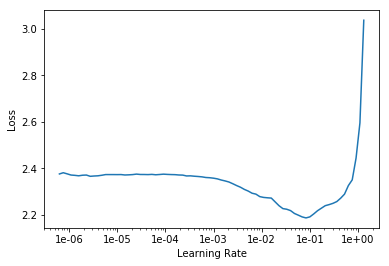

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-2
moms = (0.7,0.8)
scale = (1**4)
cycles = 20

In [ ]:
learn.fit_one_cycle(cycles, lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.694636,1.367048,0.554500,00:12
1,1.327646,1.139838,0.624500,00:13
2,1.208520,1.089448,0.649500,00:13
3,1.192155,1.079458,0.654500,00:12
4,1.176738,1.072330,0.653750,00:13
5,1.066269,1.082941,0.670250,00:13
6,1.039310,1.067451,0.669250,00:13
7,1.016304,1.035586,0.671750,00:12
8,0.990714,1.040993,0.681250,00:13
9,0.923841,1.015173,0.680250,00:12


In [ ]:
learn.fit_one_cycle(cycles, lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.681482,1.088964,0.693750,00:12
1,0.667199,1.115001,0.690250,00:12
2,0.726251,1.089911,0.697250,00:13
3,0.742061,1.106566,0.693750,00:12
4,0.749401,1.079967,0.692500,00:13
5,0.811146,1.114923,0.689750,00:13
6,0.808382,1.062313,0.687500,00:13
7,0.783303,1.117974,0.685500,00:13
8,0.777148,1.100301,0.700000,00:12
9,0.727977,1.109928,0.690250,00:13


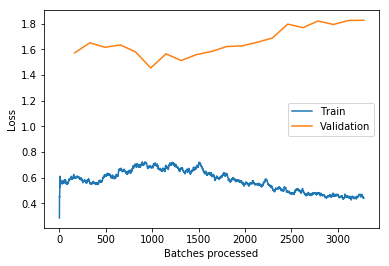

In [16]:
learn.recorder.plot_losses()

In [ ]:
learn.save('2020_03_23_sep_ff_ind_other')

In [439]:
learn.load('2020_03_23_sep_ff_only')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (19211 items)
x: TextList
xxbos   s o u t h e r n   f r i e d   c h i c k e n     a n d     p i z z a,xxbos   j     a n d     d   k e b a b,xxbos   m a h a r a n i   i n d i a n   c u i s i n e,xxbos   s w e e t   j a m r o c k,xxbos   z a a f r a n
y: CategoryList
Fast Food,Fast Food,Indian,Fast Food,Indian
Path: .;

Valid: LabelList (2400 items)
x: TextList
xxbos   j a s m i n e   i n n,xxbos   t a n d o o r i   h a v e n,xxbos   s h a k e xxunk   w a f f l e   n   r o l l,xxbos   c h e n n a i   d o s a   a r t i s a n z,xxbos   c a f e     b a g e l
y: CategoryList
Chinese,Indian,Desserts,Indian,Sand/Caf/Bake
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(46, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(46, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 115

In [440]:

interp2 = TextClassificationInterpretation(learn, *learn.get_preds(with_loss=True, ordered=True))

In [441]:
#txt_ci.show_top_losses(20)
blah = interp2.show_top_losses(10000)


Text,Prediction,Actual,Loss,Probability
xxbos k a b a b j i,Indian,Sand/Caf/Bake,16.13,0.00
xxbos c h i c h i n i,Fast Food,Sand/Caf/Bake,14.92,0.00
xxbos a p r i l ' s c a f e,Sand/Caf/Bake,Desserts,14.75,0.00
xxbos t i k k a d e l i g h t,Indian,Sand/Caf/Bake,14.50,0.00
xxbos s u g a r l u m p,Desserts,Sand/Caf/Bake,13.42,0.00
xxbos p a p a s f i s h a n d c h i p s,Fish & Chips,Sand/Caf/Bake,13.32,0.00
xxbos e m o c h i,Indian,Desserts,13.10,0.00
xxbos c o o p e r t h a i r e s t a u r a n t,Chinese,Sand/Caf/Bake,12.97,0.00
xxbos t u c k i n n,Chinese,Desserts,12.61,0.00
xxbos m o n o l o s,Fast Food,Desserts,12.43,0.00


In [37]:
my_top_losses = interp2.top_losses()
my_ds = interp2.data.dl('Valid').dataset
my_classes = interp2.data.valid_ds.classes
my_preds_class = interp2.pred_class
tl_val,tl_idx = my_top_losses


items = []
for idx in tl_idx:
    tx,cl = interp2.data.valid_ds[idx]
    cl = cl.data
    txt =  ' '.join([''.join(i.split()) for i in re.split(r' {2,}',tx.text)])[6:]
    tmp = [txt, f'{my_classes[my_preds_class[idx]]}', f'{my_classes[cl]}']
    items.append(tmp)
items = np.array(items)
names = ['Text', 'Prediction', 'Actual']
df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)

In [167]:
df.to_csv('13_01_2020_errors.csv', index=False)

In [442]:
cm = interp2.confusion_matrix()

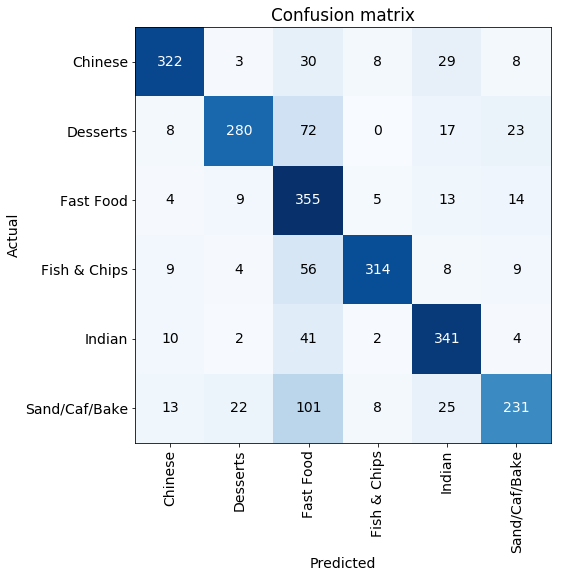

In [443]:
plt.rcParams.update({'font.size': 14})
interp2.plot_confusion_matrix(figsize=(8,8))

In [444]:
#Precision = tp / tp + fp
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [445]:
recall

array([0.805 , 0.7   , 0.8875, 0.785 , 0.8525, 0.5775])

In [446]:
precision

array([0.879781, 0.875   , 0.541985, 0.931751, 0.787529, 0.799308])

In [447]:
precision.mean()

0.8025589537111673

In [448]:
recall.mean()

0.7679166666666667

In [23]:
learn.predict("mamoods mirch")

(Category Desserts,
 tensor(2),
 tensor([0.1397, 0.0117, 0.3502, 0.1343, 0.0332, 0.0265, 0.0559, 0.1784, 0.0701]))

In [24]:
learn.predict("fryer tuck")

(Category Fish & Chips,
 tensor(4),
 tensor([3.3629e-07, 1.2309e-03, 3.5925e-06, 8.1342e-04, 9.9777e-01, 9.5526e-05,
         4.4523e-06, 3.9081e-05, 4.0542e-05]))

In [25]:
learn.predict("jade garden")

(Category Chinese,
 tensor(1),
 tensor([2.3990e-07, 9.9865e-01, 2.2686e-07, 2.7119e-04, 5.1614e-05, 9.7042e-04,
         1.6681e-06, 3.7176e-05, 1.4342e-05]))

In [22]:
learn.predict("jerk house")

(Category Fast Food,
 tensor(2),
 tensor([0.2168, 0.0406, 0.6402, 0.0161, 0.0781, 0.0083]))